### Importando

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

In [3]:
3600*24 * 4331

374198400

In [ ]:
                k1_x = body.v_x
                k1_y = body.v_y
                k1_vx = a_x
                k1_vy =  a_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k1_x, body.p_y + k1_y])
                
                k2_x = body.v_x
                k2_y = body.v_y
                k2_vx = ax_new
                k2_vy = ay_new
                
                body.p_x += step * (k1_x + k2_x)/2 
                body.p_y += step * (k1_y + k2_y)/2 
                body.v_x += step * (k1_vx + k2_vx)/2
                body.v_y += step * (k1_vy + k2_vy)/2

### Defining constants

### The body class

In [2]:
class Body:
    ## All vectors are decomposed in x-axis and y-axis
    ## p = (x,y) -> Actual Position Vector
    ## v = (x,y) -> Actual Velocity Vector
    ## pos_x -> List of all x-axis positions over time
    ## pos_y -> List of all y-axis positions over time
    ## color -> Orbit trace and planet color
    
    def __init__(self, name_of = 'UNNAMED', color_of = 'gray'):
        self.name = name_of
        self.color = color_of
        
    mass = 0
    v_x = v_y = v_x0 = v_y0 = 0
    p_x = p_y = p_x0 = p_y0 = 0
    pos_x = []
    pos_y = []
    theta = 0
    kinetic = 0
    potential = 0
    momentum = 0

    def acceleration(self, bodies, pos = [0,0], retangle = False, retpe = False, G = 6.67428e-11, retm = False):
        acc_x = acc_y = 0
        t = -5
        pe = 0
        ke = 0
        for other in bodies:
            if self is other:
                continue
            d_x = (other.p_x - pos[0])
            d_y = (other.p_y - pos[1])
            d = math.sqrt(d_x**2 + d_y**2) ## Calculate the distance between the bodies
            if d == 0:
                raise ValueError('The bodies %r and %r collided' %(self.name, other.name))
            
            ## Compute acceleration OTHER causes on THIS
            acc = G * other.mass / d**2
            
            ## Compute potential Energy
            if retpe:
                pe += G * other.mass * self.mass / d
                ke += 1/2 * self.mass * (self.v_x**2 + self.v_y**2)
                energy = ke - pe
            ## Decomposing the acceleration on x-axis and y-axis
            theta = math.atan2(d_y, d_x)
            a_x = acc*math.cos(theta)
            a_y = acc*math.sin(theta)
            if other.name == 'Sun':
                t = theta
            acc_x += a_x
            acc_y += a_y
            
        if retm: 
            v = self.v_x**2 + self.v_y**2 #v^2
            dsun = self.p_x**2 + self.p_y**2
            try:
                momentum = math.sqrt(dsun * (self.mass**2 * v) - (self.p_x * self.v_x * self.mass + self.mass * self.p_y * self.v_y)**2)
            except:
                momentum = 0
        if retangle and retpe and retm:
            return acc_x, acc_y, t, energy, momentum
        else:
            return acc_x, acc_y
        
    def l_momentum(self):
        dist = self.p_x**2+self.p_y**2
        vel = math.sqrt(self.v_x**2+self.v_y**2)
        if vel == 0: vel = 1
        l = 2*math.pi*self.mass*dist/vel
        return l

### Simulation

In [3]:
def simulate(bodies, step = 3600, period = 365, method = 'euler', G = 6.67428e-11):
    count = 0
    pos = {}
    angle = {}
    energy = {}
    momentum = {}
    for body in bodies:
        pos[body.name] = []
        angle[body.name] = []
        energy[body.name] = []
        momentum[body.name] = []
        ## Routine that resets body position state in each simulation
        body.p_x = body.p_x0
        body.p_y = body.p_y0
        body.v_x = body.v_x0
        body.v_y = body.v_y0
        
    while count < period:
        acc = {}
        for body in bodies:
            acc_x = acc_y = 0
            for other in bodies:
                if body is other:
                    continue
                acc_x, acc_y, theta_body, body.energy, body.momentum = body.acceleration(bodies, pos = [body.p_x, body.p_y], retm = True, retangle = True, retpe = True)
                acc[body] = (acc_x, acc_y)
                body.angle = theta_body

        for body in bodies:
            pos[body.name].append((body.p_x,body.p_y))
            angle[body.name].append(body.angle)
            energy[body.name].append(body.energy)
            momentum[body.name].append(body.momentum)
            
            a_x, a_y = acc[body]
            
            if method == 'euler-cromer':
            ## Sympletic 1st-order Euler
                body.v_x += a_x * step
                body.v_y += a_y * step

                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
            elif method == 'rk4':
            ## Runge-kutta 4th-order
                k1_x = step * body.v_x
                k1_y = step * body.v_y
                k1_vx = step * a_x
                k1_vy = step * a_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k1_x/2, body.p_y + k1_y/2])
                
                vhalf_x = body.v_x + 0.5 * step * ax_new
                vhalf_y = body.v_y + 0.5 * step * ay_new
                
                k2_x = step * vhalf_x
                k2_y = step * vhalf_y
                k2_vx = step * ax_new
                k2_vy = step * ay_new
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k2_x/2, body.p_y + k2_y/2])
                
                vhalf_x = body.v_x + 0.5 * step * ax_new
                vhalf_y = body.v_y + 0.5 * step * ay_new
                
                k3_x = step * vhalf_x
                k3_y = step * vhalf_y
                k3_vx = step *  ax_new
                k3_vy = step *  ay_new
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x + k3_x, body.p_y + k3_y])
                
                vhalf_x = body.v_x + step * ax_new
                vhalf_y = body.v_y + step * ay_new
                
                k4_x = step * vhalf_x
                k4_y = step * vhalf_y
                k4_vx = step * ax_new
                k4_vy = step * ay_new
                
                body.p_x += (k1_x + 2*(k2_x + k3_x)+ k4_x)/6 
                body.p_y += (k1_y + 2*(k2_y + k3_y)+ k4_y)/6
                body.v_x += (k1_vx + 2*(k2_vx + k3_vx)+ k4_vx)/6 
                body.v_y += (k1_vy + 2*(k2_vy + k3_vy)+ k4_vy)/6
                
                
            elif method == 'velocity-verlet':
            ## Velocity Verlet / Leapfrog - Sympletic 2nd-order methods
                vhalf_x = body.v_x +  0.5 * step * a_x
                vhalf_y = body.v_y +  0.5 * step * a_y
                
                body.p_x += vhalf_x * step
                body.p_y += vhalf_y * step
                
                ax_new, ay_new = body.acceleration(bodies, pos = [body.p_x, body.p_y])
                
                body.v_x = vhalf_x + ax_new * 0.5 * step
                body.v_y = vhalf_y + ay_new * 0.5 * step
            
            elif method == 'position-verlet':
            ## Velocity Verlet / Leapfrog - Sympletic 2nd-order methods
                phalf_x = body.p_x +  0.5 * step * body.v_x
                phalf_y = body.p_y +  0.5 * step * body.v_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [phalf_x, phalf_y])
                
                body.v_x += ax_new * step
                body.v_y += ay_new * step
                
                body.p_x = phalf_x + body.v_x * step/2
                body.p_y = phalf_y + body.v_y * step/2
            
            elif method == 'leapfrog':
                w = 2**(1./3.)
                f = 2 - w
                
                lf1 = (0.5 * step / f)
                p1_x = body.p_x + lf1 * body.v_x
                p1_y = body.p_y + lf1 * body.v_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [p1_x, p1_y])
                
                lf2 = step / f
                v2_x = body.v_x + lf2 * ax_new
                v2_y = body.v_y + lf2 * ay_new
                
                lf3 = (1 - w) * step * 0.5 / f
                p3_x = p1_x + lf3 * v2_x
                p3_y = p1_y + lf3 * v2_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [p3_x, p3_y])
                
                lf4 = -step * w / f
                v4_x = v2_x + lf4 * ax_new
                v4_y = v2_y + lf4 * ay_new
                
                lf5 = (1 - w) * step * 0.5 / f
                p5_x = p3_x + lf5 * v4_x
                p5_y = p3_y + lf5 * v4_y
                
                ax_new, ay_new = body.acceleration(bodies, pos = [p5_x, p5_y])
                
                lf6 = (step / f)
                body.v_x = v4_x + lf6 * ax_new
                body.v_y = v4_y + lf6 * ay_new
                
                lf7 = (step * 0.5 / f)
                body.p_x = p5_x + lf7 * body.v_x
                body.p_y = p5_y + lf7 * body.v_y
                
            else:
            ## 1st-order Euler
                body.p_x += body.v_x * step
                body.p_y += body.v_y * step
                
                body.v_x += a_x * step
                body.v_y += a_y * step
        count += 1
    return pos, angle, energy, momentum

### Plotter

In [4]:
def orbit_plotter(pos, bodies, title = 'Orbits', scale = False):
    for b in bodies:
        b.pos_x = [i[0] for i in pos[b.name]]
        b.pos_y = [i[1] for i in pos[b.name]]
    
    plt.figure(figsize=(10,10))
    
    for b in bodies:
        plt.plot(b.pos_x, b.pos_y, label = b.name, color = b.color, linestyle=':' )
        plt.scatter(b.pos_x[-1],b.pos_y[-1], color = b.color)
    
    plt.legend()
    plt.grid(alpha=0.2)

    
    ax = plt.gca()
    ax.set_facecolor('black')
    
    plt.xlabel('Latitudinal distance in AU')
    plt.ylabel('Longitudinal distance in AU')
        
    plt.title(title)
    plt.show()
    return ax

In [5]:
(108747859.3**2 + 6450489.855**2)**0.5

108939000.00322223

In [6]:
sun = Body('Sun', 'yellow')
sun.mass = 1.98855e30
sun.size = 20

earth = Body('Earth', 'blue')
earth.mass = 5.9742e24
earth.p_x0 = 152.1e9
earth.v_y0 = 29.783e3
earth.size = 1

venus = Body('Venus', 'pink')
venus.mass = 4.8685e24
venus.p_x0 = 108.9e9
venus.v_y0 = -35.02e3
venus.size = 0.95
    
mercury = Body('Mercury', 'purple')
mercury.mass = 0.3e24
mercury.p_x0 = 69.8e9
mercury.v_y0 = 47.7e3
mercury.size = 0.38
    
mars = Body('Mars', 'red')
mars.mass = 0.642e24
mars.p_x0 = 249.2e9
mars.v_y0 = 24.1e3
mars.size = 0.53
    
jupiter = Body('Jupiter', 'orange')
jupiter.mass = 1.898e27
jupiter.p_x0 = 816.6e9
jupiter.v_y0 = 13.1e3
jupiter.size = 11.2
    
saturn = Body('Saturn', 'brown')
saturn.mass = 5.68e26
saturn.p_x0 = 1514.5e9
saturn.v_y0 = 9.7e3
saturn.size = 9.45
    
uranus = Body('Uranus', 'green')
uranus.mass = 8.6e25
uranus.p_x0 = 3003.6e9
uranus.v_y0 = 6.8e3
uranus.size = 4
    
neptune = Body('Neptune', 'dodgerblue')
neptune.mass = 1.02e26
neptune.p_x0 = 4545.7e9
neptune.v_y0 = 5.4e3
neptune.size = 3.8
    
halley = Body('Halley', 'white')
halley.mass = 1.02e14
halley.p_x0 = 5248.2672e9
halley.v_y0 = 1e3

pluto = Body('Pluto', 'purple')
pluto.mass = 0.0146e24
pluto.p_x0 = 737.9e9
pluto.v_y0 = 4.7e3

## Defining Aphelions

In [7]:
data_aphelions = { 'Mercury' : 69.8e6, 'Venus' : 108.9e6, 'Earth': 152.1e6, 'Mars' : 249.2e6, 'Jupiter' : 816.6e6, 'Saturn' : 1514.5e6, 'Uranus' : 3003.6e6, 'Neptune' : 4545.7e6, 'Pluto' : 737.9e6}
data_perihelions = {'Mercury' : 46e6, 'Venus' : 107.5e6, 'Earth': 147.1e6, 'Mars' : 206.6e6, 'Jupiter' : 740.5e6, 'Saturn' : 1352.6e6, 'Uranus' : 2741.3e6, 'Neptune' : 4444.5e6, 'Pluto' : 4436.8e6}

### Full Solar System

In [8]:
bodies = [sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune]
bodies_jp = [sun, earth, venus, mars, mercury, jupiter]
bodies_inner = [sun, earth, venus, mars, mercury]
bodies_outter = [sun, jupiter, saturn, uranus, neptune]

## Names of Planets

In [9]:
bodies_names = [i.name for i in bodies]

### Conversion

3600 s - 1 hr <br>
100.000 hrs - 11.4 yrs

100.000 periodos rodam em 2.5min

10.000 rodando em 11s

In [10]:
3600*24

86400

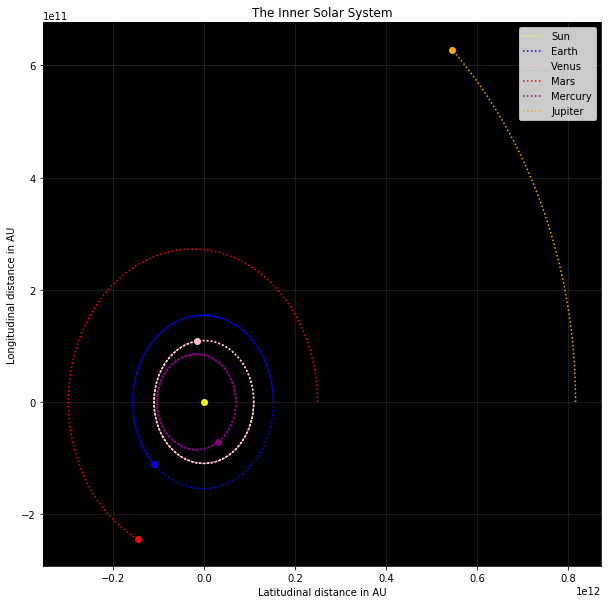

A simulação foi feita em 16.55660915374756 segundos


In [11]:
start_time = time.time()
t = 15000
h = 3600
pos, angle, energy, momentum = simulate(bodies, period = t, method='rk4', step = h)
#plin = orbit_plotter(pos, bodies_inner, title='The Inner Solar System')
pl = orbit_plotter(pos, bodies_jp, title='The Inner Solar System')
#plout = orbit_plotter(pos, bodies, title='The Outer Solar System')
end_time = time.time()
print('A simulação foi feita em %s segundos' % (end_time - start_time))

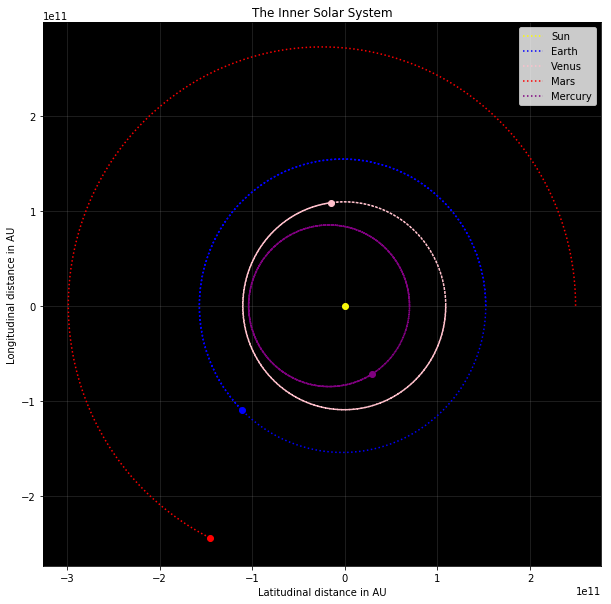

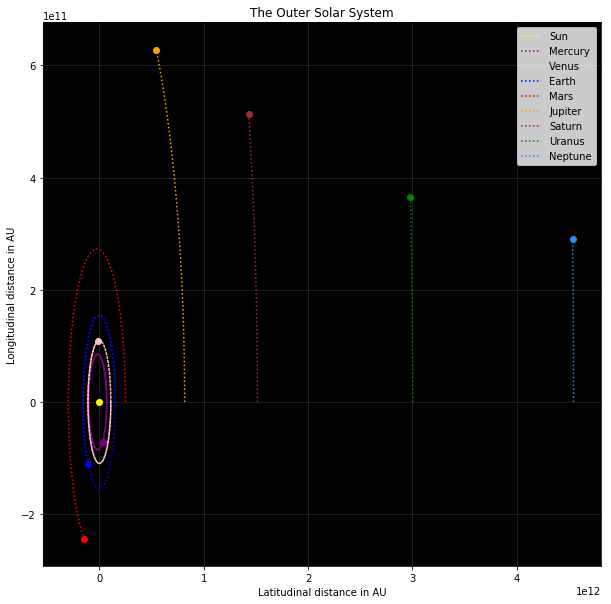

In [12]:
plin = orbit_plotter(pos, bodies_inner, title='The Inner Solar System')
#pl = orbit_plotter(pos, bodies_jp, title='The Inner Solar System')
plout = orbit_plotter(pos, bodies, title='The Outer Solar System')

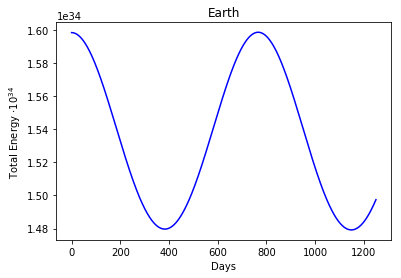

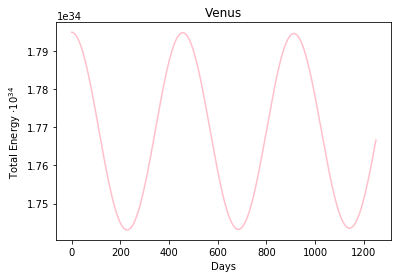

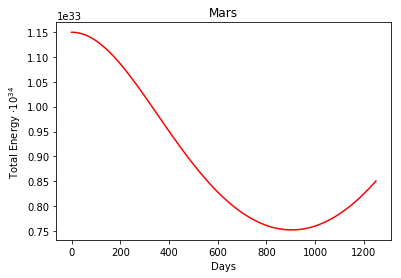

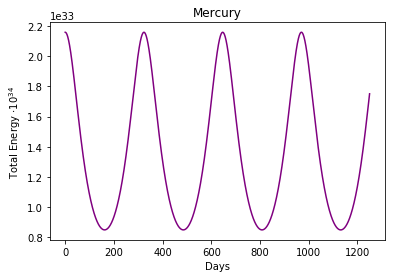

In [21]:
ts = np.linspace(0,2*t/24,t)
for b in bodies_inner[1:]:
    plt.plot(ts, energy[b.name], color = b.color)
    plt.xlabel('Days')
    plt.ylabel('Total Energy $\cdot 10^{34}$')
    plt.title(b.name)
    plt.show()

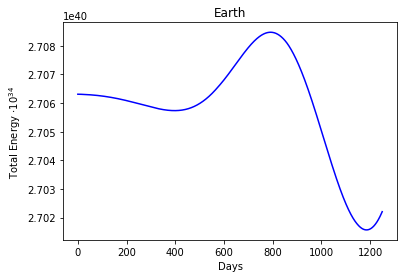

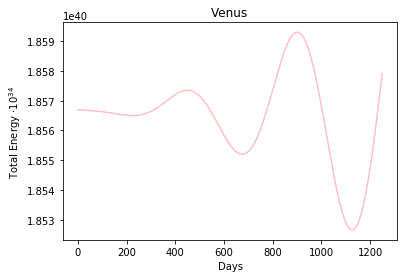

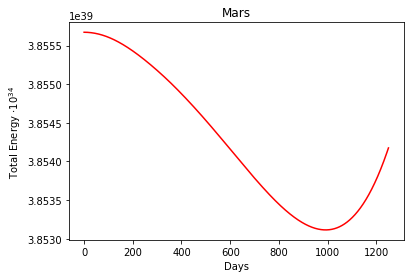

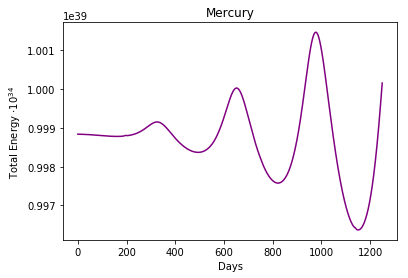

In [22]:
ts = np.linspace(0,2*t/24,t)
for b in bodies_inner[1:]:
    plt.plot(ts, momentum[b.name], color = b.color)
    plt.xlabel('Days')
    plt.ylabel('Total Energy $\cdot 10^{34}$')
    plt.title(b.name)
    plt.show()

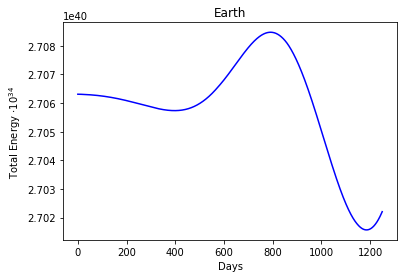

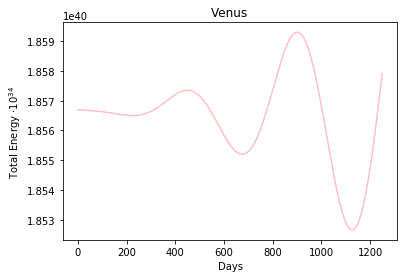

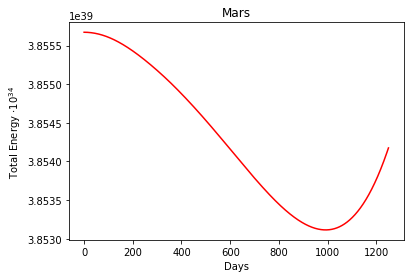

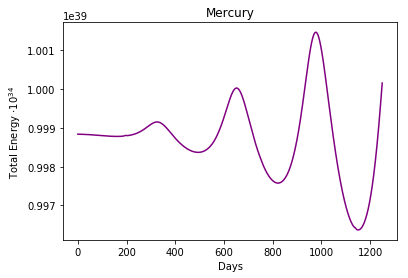

In [23]:
ts = np.linspace(0,2*t/24,t)
for b in bodies_inner[1:]:
    plt.plot(ts, momentum[b.name], color = b.color)
    plt.xlabel('Days')
    plt.ylabel('Total Energy $\cdot 10^{34}$')
    plt.title(b.name)
    plt.show()

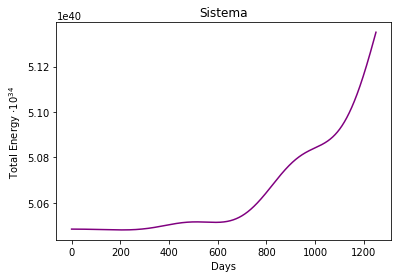

In [24]:
ts = np.linspace(0,2*t/24,t)
m = [0]*t
for b in bodies_inner:
    for i in range(0,len(momentum[b.name])):
        m[i] += momentum[b.name][i]

plt.plot(ts, m, color = b.color)
plt.xlabel('Days')
plt.ylabel('Total Energy $\cdot 10^{34}$')
plt.title('Sistema')
plt.show()

In [25]:
dist = [i[1]**2+i[0]**2 for i in pos['Earth']]

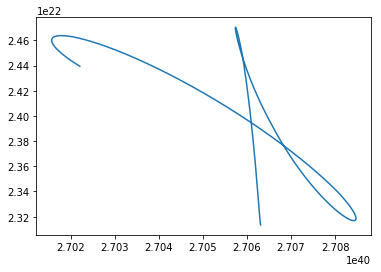

In [18]:
plt.plot(momentum['Earth'], dist)

In [19]:
def calc_aphelion(pos):
    aphelion = 0
    for i in pos:
        dist = math.sqrt(i[0]**2+i[1]**2)
        if dist > aphelion: aphelion = dist
    return aphelion

def calc_perihelion(pos):
    pherihelion = 50*AU
    for i in pos:
        dist = math.sqrt(i[0]**2+i[1]**2)
        if dist < pherihelion: pherihelion = dist
    return pherihelion

def calc_ecc(ap, pe):
    e = 1-(2/((ap/pe)+1))
    return e

In [20]:
aphelion = {}
perihelion = {}
for b in bodies[1:]:
    aphelion[b.name] = calc_aphelion(pos[b.name])
    perihelion[b.name] = calc_perihelion(pos[b.name])

NameError: name 'AU' is not defined

In [ ]:
eccentricity = {}
for b in bodies[1:]:
    eccentricity[b.name] = calc_ecc(aphelion[b.name], perihelion[b.name])

In [ ]:
eccentricity

In [2]:
def third_law(t0, tf):
    def f(t):
        fact = a*b/2
        fact2 = t - math.atan2(((b-a)*math.sin(2*t))/(b+a+(b-a)*math.cos(2*t)))
        return fact * fact2
    return f(tf) - f(t0)